In [71]:
import sys
sys.path.append('..')
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.Schrodinger.Schrodinger2D_baseline_nohvd import SchrodingerNet, load_checkpoint, getDefaults
from src.Schrodinger.Dataset.Schrodinger2DDatasets import SchrodingerEquationDataset

The following code initializes our models and loads a pretrained model from `pathModel`. 

In [32]:
pathModel = '../data/Schrodinger/pretrained_models/model_11180.pt'
coordinateSystem, numOfEnergySamplingPointsX, numOfEnergySamplingPointsY, tmax = getDefaults()
numBatches = 300
batchSizePDE = 1
ICdatasize = 100
ds = SchrodingerEquationDataset(coordinateSystem, numOfEnergySamplingPointsX, numOfEnergySamplingPointsY, ICdatasize, numBatches, batchSizePDE, useGPU=False)

model = SchrodingerNet(ds.lb, ds.ub, numOfEnergySamplingPointsX, numOfEnergySamplingPointsY, noFeatures=300,noLayers=8)
load_checkpoint(model, pathModel)

`queryModel` allows us to get the output of the neural network at the whole grid at some predefined timepoint `timestep`. The range of `timestep` is 0..1000. `queryGroundtruth` basically does the same but computes the ground-truth solution of the quantum harmonic oscillator based on our analytical solution.

In [95]:
def queryModel(model, timestep, coordinateSystem):
    x, y, t = SchrodingerEquationDataset.getInput(timestep,coordinateSystem)
    x = torch.Tensor(x).float()
    y = torch.Tensor(y).float()
    t = torch.Tensor(t).float()
    inputX = torch.stack([x, y, t], 1)
    UV = model(inputX).detach().cpu().numpy()
    uPred = UV[:, 0].reshape((200,200))
    vPred = UV[:, 1].reshape((200,200))
    return uPred, vPred

def queryGroundtruth(timestep, coordinateSystem):
    uVal, vVal = SchrodingerEquationDataset.getFrame(timestep,coordinateSystem)
    uVal = np.array(uVal).reshape((200,200))
    vVal = np.array(vVal).reshape((200,200))
    return uVal, vVal

In [98]:
tQuery = 750

uGt, vGt = queryGroundtruth(tQuery,coordinateSystem)
uPred, vPred = queryModel(model, tQuery, coordinateSystem)

The solution of our QHO is an imaginary number for what reason we visualize the real and imaginary part in different figures.

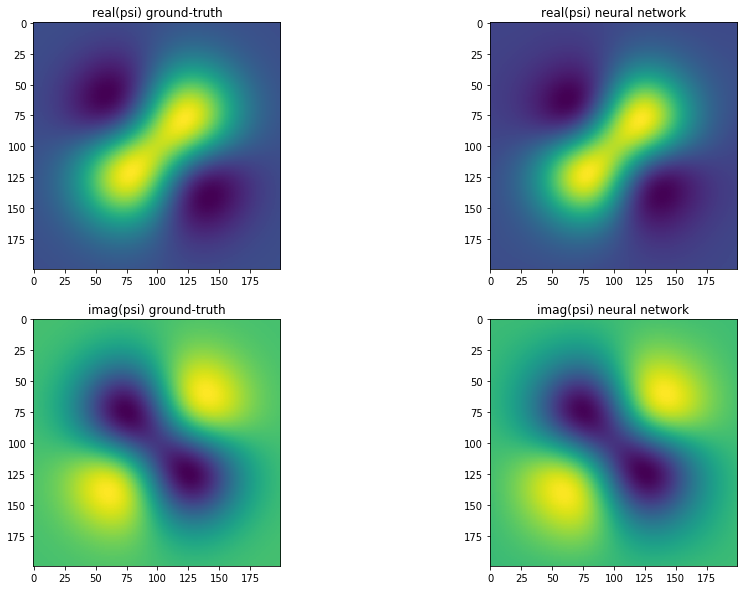

In [99]:
f, axarr = plt.subplots(2, 2, figsize=(15, 10))
cm = ['RdBu_r', 'viridis']

pcm = axarr[0,0].imshow(uGt)
axarr[0,0].set_title('real(psi) ground-truth')

pcm = axarr[0,1].imshow(uPred)
axarr[0,1].set_title('real(psi) neural network')

pcm = axarr[1,0].imshow(vGt)
axarr[1,0].set_title('imag(psi) ground-truth')

pcm = axarr[1,1].imshow(vPred)
axarr[1,1].set_title('imag(psi) neural network')

plt.show()